In [1]:
import scanpy as sc
import anndata as ad
import infercnvpy as cnv 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/home/hanxue/miniconda3/envs/scseq/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = sc.read_h5ad("/data/hanxue/adata-xwt-annotated.h5ad")
adata

AnnData object with n_obs × n_vars = 159054 × 41733
    obs: 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', 'major_type', 'molecular_type', 'leiden_harmony', 'major_type_harmony', 'minor_type', 'minor-type', 'gender', 'doublet_score', 'predicted_doublet', 'leiden-harmony-female', 'majorType-Female', 'epi-subtype', 'treat', 'leiden-1', 'annotation'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annotation_colors', 'batch_colors', 'dendrogram_annotation', 'dendrogram_leiden', 'dendrogram_leiden-1', 'gender_colors', 'hvg', 'leiden', 'leiden-1_colors', 'leiden-harmony-female_colors', 'leiden_colors', 'leiden_harmony_colors', 'log1p', 'majorType-Female_colors', 'major_type_colors', 'major_type_harmony_colors', 'minor-type_colors', 'minor_

In [3]:
def MergeSubAdata(adata, subAdata, obsName, subObsName):
    obs = pd.Series(list(adata.obs[obsName].copy()), index=adata.obs_names)
    subObs = pd.Series(list(subAdata.obs[subObsName].copy()), index=subAdata.obs_names)
    obs.loc[subObs.index] = subObs
    return pd.DataFrame(obs, columns=[obsName])


def marker(adata, groupby, method='wilcoxon', prefix=''):
    sc.tl.rank_genes_groups(adata, groupby = groupby, method = method)
    sc.tl.dendrogram(adata, groupby=groupby, use_rep='X_pca_harmony')
    sc.pl.rank_genes_groups_dotplot(adata, groupby = groupby, save=prefix+groupby+'.svg')
    return adata

def clu(adata, key_added="majorType-fix", n_neighbors=50, n_pcs=30, rep='X_pca_harmony', do_har=False, max_iter=20, do_scrublet=False, har_key='batch', resolution=1):
    # Computing the neighborhood graph
    if do_scrublet:
        n0 = adata.shape[0]
        print("{0} Cell number: {1}".format(key_added, n0))
        sc.external.pp.scrublet(adata)
        adata = adata[adata.obs['predicted_doublet']==False,:].copy()
        print("{0} Cells retained after scrublet, {1} cells reomved.".format(adata.shape[0], n0-adata.shape[0]))
    else:
        print("Ignoring processing doublet cells...")
    if do_har and len(adata.obs[har_key].cat.categories) > 1:
        sc.external.pp.harmony_integrate(adata, key=har_key,max_iter_harmony=max_iter)
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    else:
        print("Evaluating neighbors only...")
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    # Run UMAP
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=resolution, key_added=key_added)
    sc.pl.umap(adata, color=key_added, legend_fontoutline=True, palette=sc.pl.palettes.default_20, legend_loc="on data")
    return adata

In [4]:
adata_Per = adata[adata.obs['major_type'] == 'PeriVascular', :]
adata_Per

View of AnnData object with n_obs × n_vars = 12734 × 41733
    obs: 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', 'major_type', 'molecular_type', 'leiden_harmony', 'major_type_harmony', 'minor_type', 'minor-type', 'gender', 'doublet_score', 'predicted_doublet', 'leiden-harmony-female', 'majorType-Female', 'epi-subtype', 'treat', 'leiden-1', 'annotation'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annotation_colors', 'batch_colors', 'dendrogram_annotation', 'dendrogram_leiden', 'dendrogram_leiden-1', 'gender_colors', 'hvg', 'leiden', 'leiden-1_colors', 'leiden-harmony-female_colors', 'leiden_colors', 'leiden_harmony_colors', 'log1p', 'majorType-Female_colors', 'major_type_colors', 'major_type_harmony_colors', 'minor-type_colors', 

In [5]:
adata_Per_tumor = adata_Per[adata_Per.obs['treat'] != 'Normal', :]

/home/hanxue/miniconda3/envs/scseq/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:667: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/home/hanxue/miniconda3/envs/scseq/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


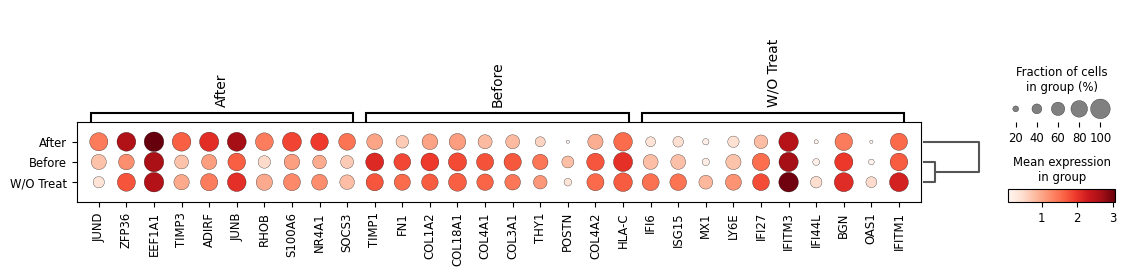

In [6]:
sc.tl.rank_genes_groups(adata_Per_tumor, groupby='treat',method='wilcoxon')
sc.tl.dendrogram(adata_Per_tumor, groupby='treat')
sc.pl.rank_genes_groups_dotplot(adata_Per_tumor, n_genes=10, groupby='treat')

In [7]:
import gseapy as gp
from gseapy import Msigdb
msig = Msigdb()
gmt = msig.get_gmt(category='mh.all', dbver="2023.2.Hs")
gmt

In [8]:
# get deg result
result = adata_Per_tumor.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})
degs

,After_names,After_scores,After_pvals,After_pvals_adj,After_logfoldchanges,Before_names,Before_scores,Before_pvals,Before_pvals_adj,Before_logfoldchanges,W/O Treat_names,W/O Treat_scores,W/O Treat_pvals,W/O Treat_pvals_adj,W/O Treat_logfoldchanges
0,JUND,49.131958,0.0,0.0,1.884304,TIMP1,33.578388,3.468837e-247,1.809562e-243,1.733705,IFI6,36.693348,9.323941e-295,1.945580e-290,2.363419
1,ZFP36,46.320728,0.0,0.0,1.975650,FN1,32.700729,1.525003e-234,7.071438e-231,1.982254,ISG15,32.897190,2.410835e-237,3.353713e-233,2.221997
2,EEF1A1,45.978809,0.0,0.0,0.721450,COL1A2,31.967083,3.127963e-224,1.186721e-220,1.440884,MX1,30.044649,2.564640e-198,2.140603e-194,2.789550
3,TIMP3,45.954765,0.0,0.0,1.692221,COL18A1,31.326515,2.032452e-215,7.068361e-212,1.131881,LY6E,28.159887,1.813433e-174,1.081143e-170,1.727318
4,ADIRF,43.670284,0.0,0.0,1.626593,COL4A1,30.639482,3.648917e-206,1.015202e-202,1.523518,IFI27,26.789040,4.335993e-158,1.809540e-154,1.539145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41728,TIMP1,-38.972515,0.0,0.0,-1.788875,JUNB,-35.111900,4.437288e-270,3.703627e-266,-1.488624,EEF1A1,-27.059299,2.968872e-161,1.376666e-157,-0.597458
41729,PRSS23,-39.537762,0.0,0.0,-2.415867,ADIRF,-36.431068,1.372133e-290,1.431581e-286,-1.623309,IER5L,-27.823517,2.253394e-170,1.175511e-166,-2.088535
41730,COL4A1,-39.691624,0.0,0.0,-1.830580,TIMP3,-37.515190,5.208149e-308,7.245056e-304,-1.662890,GNAS,-28.818386,1.262120e-182,8.778673e-179,-1.064392
41731,IFI27,-41.399887,0.0,0.0,-1.770391,ZFP36,-40.251060,0.000000e+00,0.000000e+00,-2.088255,CD81,-32.562664,1.385815e-232,1.445855e-228,-1.182225


In [9]:
# subset up or down regulated genes
degs_sig = degs[degs.After_pvals_adj < 0.05]
degs_up = degs_sig[degs_sig.After_logfoldchanges > 0.5]
degs_dw = degs_sig[degs_sig.After_logfoldchanges < -0.5]

In [10]:
enr_up = gp.enrichr(degs_up.After_names,
                    gene_sets='KEGG_2021_Human',
                    outdir=None)
cc_up = gp.enrichr(degs_up.After_names,
                    gene_sets='GO_Cellular_Component_2023',
                    outdir=None)
bp_up = gp.enrichr(degs_up.After_names,
                    gene_sets='GO_Biological_Process_2023',
                    outdir=None)
mf_up = gp.enrichr(degs_up.After_names,
                    gene_sets='GO_Molecular_Function_2023',
                    outdir=None)
hm_up = gp.enrichr(degs_up.After_names,
                    gene_sets='MSigDB_Hallmark_2020',
                    outdir=None)

In [11]:
enr_down = gp.enrichr(degs_dw.After_names,
                    gene_sets='KEGG_2021_Human',
                    outdir=None)
cc_down = gp.enrichr(degs_dw.After_names,
                    gene_sets='GO_Cellular_Component_2023',
                    outdir=None)
bp_down = gp.enrichr(degs_dw.After_names,
                    gene_sets='GO_Biological_Process_2023',
                    outdir=None)
mf_down = gp.enrichr(degs_dw.After_names,
                    gene_sets='GO_Molecular_Function_2023',
                    outdir=None)
hm_down = gp.enrichr(degs_dw.After_names,
                    gene_sets='MSigDB_Hallmark_2020',
                    outdir=None)

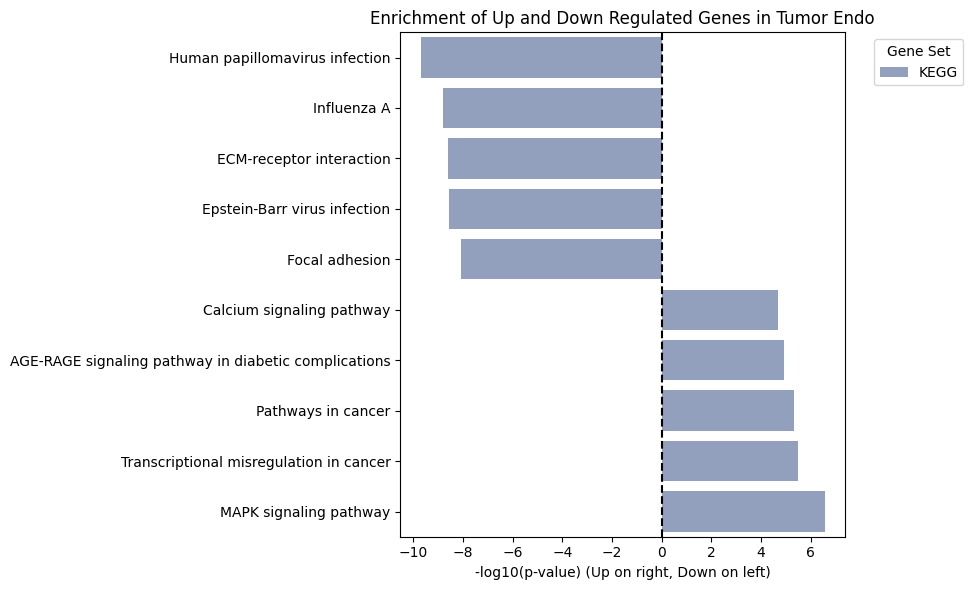

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 拼接所有up和down富集结果
def prepare_df(df, label):
    df = df.copy()
    df['Gene_set'] = label
    return df

# 合并top15条目来自每个数据库
df_up = pd.concat([
    prepare_df(enr_up.res2d.head(5), 'KEGG')
])
df_down = pd.concat([
    prepare_df(enr_down.res2d.head(5), 'KEGG')
])

# 添加方向、统一-log10(pval)
df_up['Direction'] = 'Up'
df_up['logp'] = -np.log10(df_up['P-value'])

df_down['Direction'] = 'Down'
df_down['logp'] = np.log10(df_down['P-value'])  # 注意：下调做正方向方便镜像

# 合并并整理
df_all = pd.concat([df_up, df_down])
df_all['Term'] = df_all['Term'].str.replace('_', ' ')
df_all['Term'] = df_all['Term'].str[:60]  # 避免标签过长

# 设置颜色
palette = {
    'KEGG': '#8b9cc4'
}

# 排序绘图
df_all = df_all.sort_values('logp')
plt.figure(figsize=(10, 6))

# 条形图
sns.barplot(
    data=df_all,
    y='Term',
    x='logp',
    hue='Gene_set',
    palette=palette,
    dodge=False
)

# 设置参考线与图例
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('-log10(p-value) (Up on right, Down on left)')
plt.ylabel('')
plt.title("Enrichment of Up and Down Regulated Genes in Tumor Endo")
plt.legend(title='Gene Set', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("figures/After_PeriVascular_KEGG_Enrichment_UPvsDOWN.svg")
plt.show()